## Laboratory work 2
Variant: 3 (27) <br>
NN architecture: AlexNet <br>
SS learning method: Proxy Labelling <br>
Dataset: Cifar10 <br>
link to dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setting random number seed

In [3]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
random_state_const = 0

In [4]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_test = torch.Generator().manual_seed(1)

### Data read

This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). However, based on this article: https://github.com/P1Analytics/Pseudo-Label-for-Deep-Neural-Networks/blob/master/Pseudo-Label%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf <br>
the difference between training NN with and without Proxy labeling is best seen on small labeled datasets. For this work I'll take 480 labeled images (training set, labeled images, 30%), then we also need to take 480 * 7 / 3 = 1120 unlabeled images (training set, unlabeled images, 70%). For the test set we will take (480 + 1120) / 5 = 320 (original CIFAR 10 dataset ratio of train and test sets is 5:1, for test set we will also ensure stratification). Resulting split:
```
1. SGD + momentum                     - tr_full_set (training set, labeled images, 83.3%) +
                                        tst_set (test set, labeled images, 16.7%)
2. SGD + momentum + Proxy_Labelling   - tr_part_lbl_set (training set, labeled images, 25%) +
                                        tr_part_non_lbl_set (training set, unlabeled images, 58.3%) +
                                        tst_set (test set, labeled images, 16.7%)
Total images used for sets: 1920
```

In [5]:
total_image_count = 1920
tst_set_len = 320
tr_full_set_len = 1600
tr_part_lbl_set_len = 480
tr_part_non_lbl_set_len = 1120

In [6]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> resize to 256 x 256 -> 
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Clear memory
del traindata
del testdata

100%|██████████| 170498071/170498071 [00:03<00:00, 48893036.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

# Create training set, labeled images, 83.3%
tr_full_set_fraction = tr_full_set_len / len(trainset)
tr_full_set, _ = torch.utils.data.random_split(trainset, [tr_full_set_fraction, 1 - tr_full_set_fraction], generator=g_train)
# Create training set, labeled images, 25% + training set, unlabeled images, 58.3% (their ratio is 3:7)
tr_part_lbl_set, tr_part_non_lbl_set = torch.utils.data.random_split(tr_full_set, [0.3, 0.7], generator=g_train)

# Create a sampler, that provides an iterable over the trainset
tr_full_loader = torch.utils.data.DataLoader(
    tr_full_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)
tr_part_lbl_loader = torch.utils.data.DataLoader(
    tr_part_lbl_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

In [8]:
# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Get sequence of labels in dataset
labels = [sample[1] for sample in testset]

# Calculate the number of splits needed
n_splits = len(testset) // tst_set_len

# Initialize StratifiedKFold with the calculated number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state_const)

# Initialize empty lists to store the indices for the new dataset
test_dataset_indices = []

# Perform the StratifiedKFold splits and keep adding indices until reaching the desired length
for _, test_indices in stratified_kfold.split(np.zeros(len(labels)), labels):
    test_dataset_indices.extend(test_indices)
    if len(test_dataset_indices) >= tst_set_len:
        break

# Ensure that the new dataset length matches the desired length
test_dataset_indices = test_dataset_indices[:tst_set_len]

# Create a new dataset with the selected indices
tst_set = torch.utils.data.Subset(testset, test_dataset_indices)

# Create a sampler for testset
tst_set_loader = torch.utils.data.DataLoader(
    tst_set, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

### Data visualization

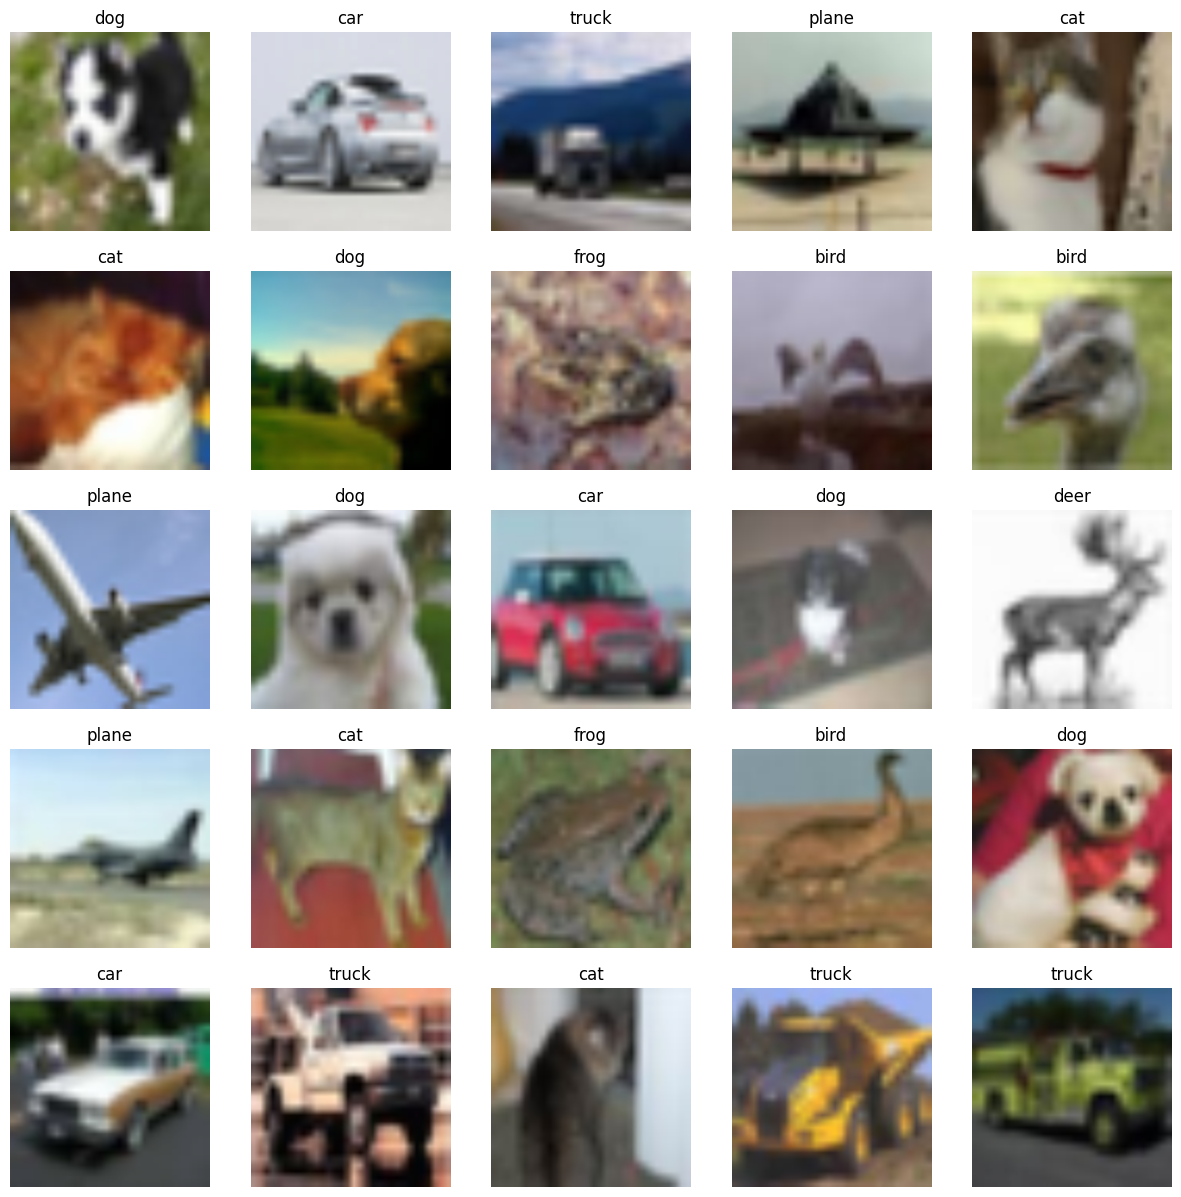

In [9]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(tr_full_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [10]:
print(f"Amount of batches processed in each epoch during full training: {tr_full_set_len / batch_size}")

Amount of batches processed in each epoch during full training: 50.0


# Non Proxy Labelling case

### Neural network setup

In [11]:
# Set up loss criterion
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)

In [12]:
# Set up untrained AlexNet neural network with modified
# classification head to 10 classes, send this NN to GPU
alexnet_non_pl = models.alexnet(num_classes=10).to(device)

# Set up stohastic gradient descent method of NN training with
# learning rate = 0.001
# momentum = 0.9
# dropout = 0.5
# (original values from scientific paper)
optimizer = optim.SGD(alexnet_non_pl.parameters(), lr=0.001, momentum=0.9)

### Network training

In [13]:
test_data_len = len(tst_set_loader)

In [14]:
# Set the number of epochs
epochs = 160
# Set the number of batches, after which info will be displayed
cycle_batch = 51
# Set the number of epochs, after which info will be displayed
cycle_epoch = 5

overfit_epoch = 110 # Determined experimentaly

# Create required arrays to store loss and accuracy
train_data_len = len(tr_full_loader)
train_loss_arr_non_pl = np.zeros(epochs)
test_loss_arr_non_pl = np.zeros(epochs)
test_accuracy_arr_non_pl = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    if (epoch + 1) % cycle_epoch == 0:
        print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_non_pl.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_full_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_non_pl(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if (batch_num + 1) % cycle_batch == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
            
        # Weights saving
        if epoch == overfit_epoch - 1:
            # Save weights to file 'AlexNet_nonPL_CIFAR10_weights.pth'
            torch.save(alexnet_non_pl.state_dict(), 'AlexNet_nonPL_CIFAR10_weights.pth')
            # To load weigths:
            # alexnet_non_pl.load_state_dict(torch.load('AlexNet_nonPL_CIFAR10_weights.pth''))
            # alexnet_non_pl.eval()
        
        # Clearing memory
        del tr_inputs
        del tr_labels
        del outputs
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_non_pl.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_non_pl(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
            
            # Clearing memory
            del tst_inputs
            del tst_labels
            del predictions
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr_non_pl[epoch] = train_loss / train_data_len
        test_loss_arr_non_pl[epoch] = test_loss / test_data_len
        test_accuracy_arr_non_pl[epoch] = test_acc / test_data_len
        
        if (epoch + 1) % cycle_epoch == 0:
            # Print out average loss and accuracy of this epoch
            print(f"\nAverage train loss: {train_loss_arr_non_pl[epoch]:.5f}")
            print(f"Average test loss: {test_loss_arr_non_pl[epoch]:.5f}, Average test acc: {test_accuracy_arr_non_pl[epoch]:.2f}%\n")

Current epoch: 5
-------

Average train loss: 2.30170
Average test loss: 2.30211, Average test acc: 0.10%

Current epoch: 10
-------

Average train loss: 2.30082
Average test loss: 2.30136, Average test acc: 0.10%

Current epoch: 15
-------

Average train loss: 2.29805
Average test loss: 2.29854, Average test acc: 0.10%

Current epoch: 20
-------

Average train loss: 2.27374
Average test loss: 2.26953, Average test acc: 0.13%

Current epoch: 25
-------

Average train loss: 2.07617
Average test loss: 2.06445, Average test acc: 0.27%

Current epoch: 30
-------

Average train loss: 1.97375
Average test loss: 2.02690, Average test acc: 0.27%

Current epoch: 35
-------

Average train loss: 1.88080
Average test loss: 1.87638, Average test acc: 0.32%

Current epoch: 40
-------

Average train loss: 1.76849
Average test loss: 1.80969, Average test acc: 0.33%

Current epoch: 45
-------

Average train loss: 1.70645
Average test loss: 1.78062, Average test acc: 0.37%

Current epoch: 50
-------

Av

### Accuracy and loss plots

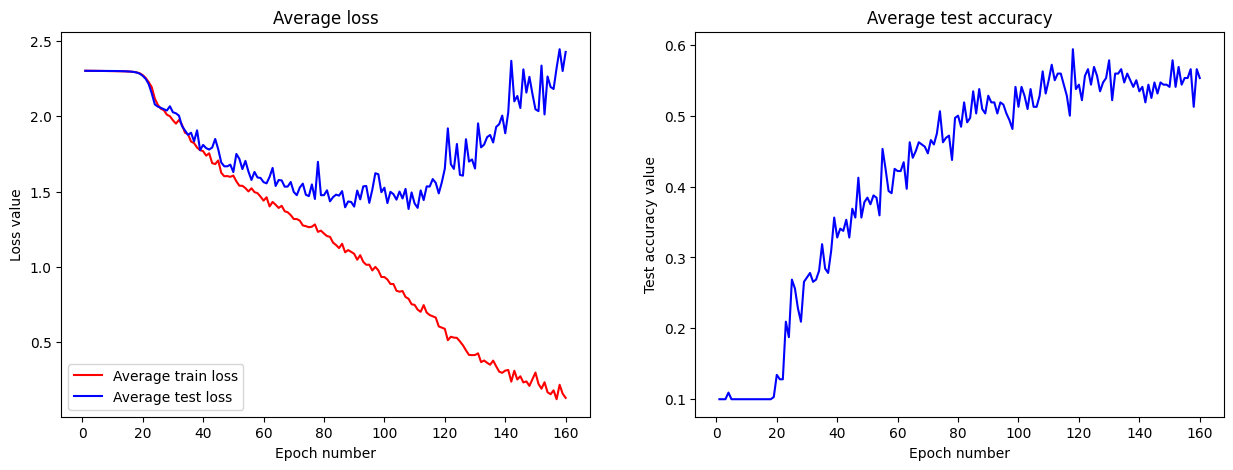

In [15]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr_non_pl, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr_non_pl,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr_non_pl, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

### As we see, the model started overfitting approximately after epoch 110, so we should stop training there.

In [16]:
print(f"\n Epoch {overfit_epoch} average train loss: {train_loss_arr_non_pl[overfit_epoch - 1]:.5f}")
print(f"Epoch {overfit_epoch} average test loss: {test_loss_arr_non_pl[overfit_epoch - 1]:.5f}, Epoch {overfit_epoch} average test acc: {test_accuracy_arr_non_pl[overfit_epoch - 1]:.2f}%\n")


 Epoch 110 average train loss: 0.74650
Epoch 110 average test loss: 1.42075, Epoch 110 average test acc: 0.55%



In [17]:
# Clear memory and cache
del alexnet_non_pl
del optimizer
gc.collect()
torch.cuda.empty_cache()

# Proxy Labelling case

### Firstly, we need to train proxy labeler. To prevent overfitting we will stop training when test loss starts to rise.

### Neural network setup

In [18]:
# Set up untrained AlexNet neural network with modified
# classification head to 10 classes, send this NN to GPU
alexnet_proxy_labeller = models.alexnet(num_classes=10).to(device)

# Set up stohastic gradient descent method of NN training with
# learning rate = 0.001
# momentum = 0.9
# (original values from scientific paper)
optimizer = optim.SGD(alexnet_proxy_labeller.parameters(), lr=0.001, momentum=0.9)

### Network training

In [19]:
# Set the number of epochs
epochs = 190
# Set the number of batches, after which info will be displayed
cycle_batch = 51
# Set the number of epochs, after which info will be displayed
cycle_epoch = 10

overfit_epoch = 150 # Determined experimentaly

# Create required arrays to store loss and accuracy
train_data_len_part = len(tr_part_lbl_loader)
train_loss_arr_labeler = np.zeros(epochs)
test_loss_arr_labeler = np.zeros(epochs)
test_accuracy_arr_labeler = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    if (epoch + 1) % cycle_epoch == 0:
        print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_proxy_labeller.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_part_lbl_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_proxy_labeller(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle_batch == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
            
        # Weights saving
        if epoch == overfit_epoch - 1:
            # Save weights to file 'AlexNet_proxy_labeler_CIFAR10_weights.pth'
            torch.save(alexnet_proxy_labeller.state_dict(), 'AlexNet_proxy_labeler_CIFAR10_weights.pth')
            # To load weigths:
            # alexnet_proxy_labeller.load_state_dict(torch.load('AlexNet_proxy_labeler_CIFAR10_weights.pth''))
            # alexnet_proxy_labeller.eval()
            
        # Clearing memory
        del tr_inputs
        del tr_labels
        del outputs
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_proxy_labeller.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_proxy_labeller(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
        
        # Clearing memory
        del tst_inputs
        del tst_labels
        del predictions
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr_labeler[epoch] = train_loss / train_data_len_part
        test_loss_arr_labeler[epoch] = test_loss / test_data_len
        test_accuracy_arr_labeler[epoch] = test_acc / test_data_len
        
        if (epoch + 1) % cycle_epoch == 0:
            # Print out average loss and accuracy of this epoch
            print(f"\nAverage train loss: {train_loss_arr_labeler[epoch]:.5f}")
            print(f"Average test loss: {test_loss_arr_labeler[epoch]:.5f}, "
                  f"Average test acc: {test_accuracy_arr_labeler[epoch]:.2f}%\n")

Current epoch: 10
-------

Average train loss: 2.30058
Average test loss: 2.30259, Average test acc: 0.11%

Current epoch: 20
-------

Average train loss: 2.29869
Average test loss: 2.30259, Average test acc: 0.10%

Current epoch: 30
-------

Average train loss: 2.29639
Average test loss: 2.30248, Average test acc: 0.10%

Current epoch: 40
-------

Average train loss: 2.29361
Average test loss: 2.30147, Average test acc: 0.10%

Current epoch: 50
-------

Average train loss: 2.28292
Average test loss: 2.29474, Average test acc: 0.10%

Current epoch: 60
-------

Average train loss: 2.24481
Average test loss: 2.25087, Average test acc: 0.13%

Current epoch: 70
-------

Average train loss: 2.12878
Average test loss: 2.14141, Average test acc: 0.17%

Current epoch: 80
-------

Average train loss: 2.01481
Average test loss: 2.10779, Average test acc: 0.24%

Current epoch: 90
-------

Average train loss: 1.95733
Average test loss: 2.13030, Average test acc: 0.25%

Current epoch: 100
-------



### Accuracy and loss plots

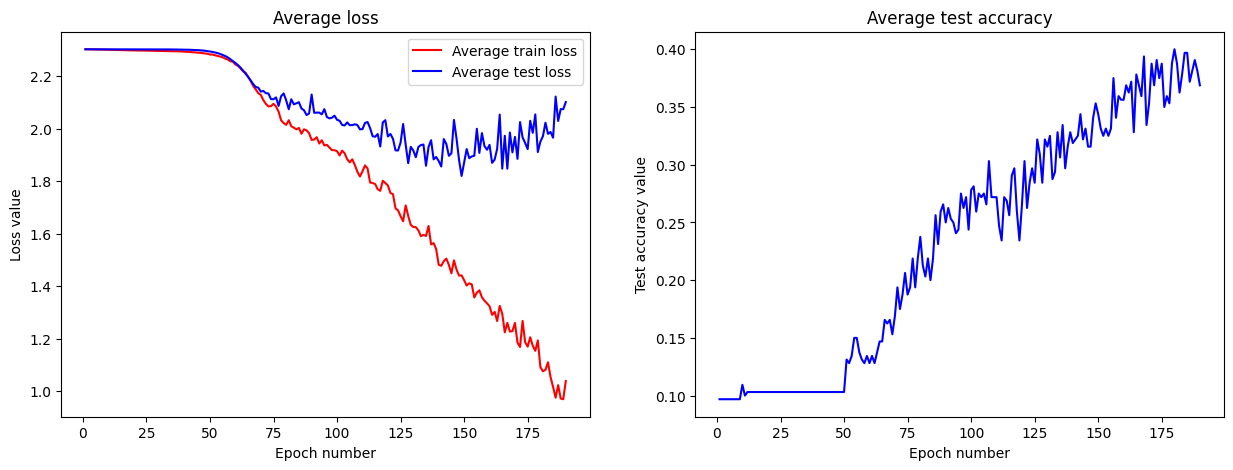

In [20]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr_labeler, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr_labeler,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr_labeler, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

### As we see, the model started overfitting approximately after epoch 150, so we should stop training there. Let's load parameters from epoch 150 to our proxy labeller and also output best loss and accuracy.

In [21]:
print(f"\n Epoch {overfit_epoch} average train loss: {train_loss_arr_labeler[overfit_epoch - 1]:.5f}")
print(f"Epoch {overfit_epoch} average test loss: {test_loss_arr_labeler[overfit_epoch - 1]:.5f}, Epoch {overfit_epoch} average test acc: {test_accuracy_arr_labeler[overfit_epoch - 1]:.2f}%\n")


 Epoch 150 average train loss: 1.42267
Epoch 150 average test loss: 1.87119, Epoch 150 average test acc: 0.34%



In [22]:
# Clear memory and cache
del optimizer
gc.collect()
torch.cuda.empty_cache()

### Predictably, the results are worse comparing to model with bigger training dataset.

In [23]:
# Weights load
alexnet_proxy_labeller.load_state_dict(torch.load('AlexNet_proxy_labeler_CIFAR10_weights.pth'))
alexnet_proxy_labeller.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [25]:
images = torch.stack([sample[0] for sample in tr_part_non_lbl_set]).to(device)
predictions = [int(elem) for elem in alexnet_proxy_labeller(images).to("cpu").argmax(dim=1)] # Predict proxy labels

pred_train_set = CustomDataset(images.to("cpu"), predictions)                                # Concatenate horizontally
concat_train_set = torch.utils.data.ConcatDataset([tr_part_lbl_set, pred_train_set])         # Concatenate vertically

# Create data loader for labeled train set + proxy labeled train set
tr_concat_set_loader = torch.utils.data.DataLoader(
    concat_train_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

# Clear memory and cache
del alexnet_proxy_labeller
del images
del predictions
gc.collect()
torch.cuda.empty_cache()

In [26]:
# Declare full proxy labelling model
alexnet_pl = models.alexnet(num_classes=10).to(device)
optimizer = optim.SGD(alexnet_pl.parameters(), lr=0.001, momentum=0.9)

In [27]:
# Set the number of epochs
epochs = 100
# Set the number of batches, after which info will be displayed
cycle_batch = 51
# Set the number of epochs, after which info will be displayed
cycle_epoch = 10

overfit_epoch = 25 # Determined experimentally

# Create required arrays to store loss and accuracy
train_loss_arr_pl = np.zeros(epochs)
test_loss_arr_pl = np.zeros(epochs)
test_accuracy_arr_pl = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    if (epoch + 1) % cycle_epoch == 0:
        print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_pl.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_concat_set_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_pl(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle_batch == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
            
        # Weights saving
        if epoch == overfit_epoch - 1:
            # Save weights to file 'AlexNet_pl_CIFAR10_weights.pth'
            torch.save(alexnet_pl.state_dict(), 'AlexNet_pl_CIFAR10_weights.pth')
            # To load weigths:
            # alexnet_pl.load_state_dict(torch.load('AlexNet_pl_CIFAR10_weights.pth'))
            # alexnet_pl.eval()

        # Clearing memory
        del tr_inputs
        del tr_labels
        del outputs
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_pl.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_pl(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
            
        # Clearing memory
        del tst_inputs
        del tst_labels
        del predictions
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr_pl[epoch] = train_loss / train_data_len
        test_loss_arr_pl[epoch] = test_loss / test_data_len
        test_accuracy_arr_pl[epoch] = test_acc / test_data_len
    
        if (epoch + 1) % cycle_epoch == 0:
            # Print out average loss and accuracy of this epoch
            print(f"\nAverage train loss: {train_loss_arr_pl[epoch]:.5f}")
            print(f"Average test loss: {test_loss_arr_pl[epoch]:.5f}, Average test acc: {test_accuracy_arr_pl[epoch]:.2f}%\n")

Current epoch: 10
-------

Average train loss: 2.06899
Average test loss: 2.18225, Average test acc: 0.17%

Current epoch: 20
-------

Average train loss: 1.57885
Average test loss: 2.02667, Average test acc: 0.29%

Current epoch: 30
-------

Average train loss: 1.15303
Average test loss: 2.23727, Average test acc: 0.32%

Current epoch: 40
-------

Average train loss: 0.90105
Average test loss: 2.42042, Average test acc: 0.33%

Current epoch: 50
-------

Average train loss: 0.84256
Average test loss: 2.60373, Average test acc: 0.38%

Current epoch: 60
-------

Average train loss: 0.71206
Average test loss: 2.82427, Average test acc: 0.35%

Current epoch: 70
-------

Average train loss: 0.61377
Average test loss: 2.78820, Average test acc: 0.38%

Current epoch: 80
-------

Average train loss: 0.53330
Average test loss: 2.63315, Average test acc: 0.37%

Current epoch: 90
-------

Average train loss: 0.42021
Average test loss: 3.02696, Average test acc: 0.38%

Current epoch: 100
-------



### Accuracy and loss plots

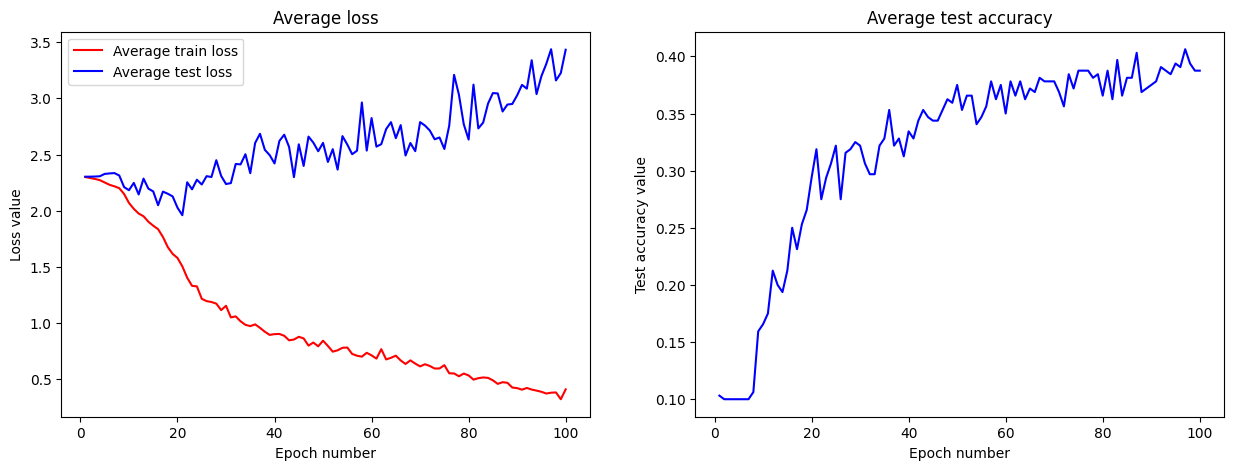

In [28]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr_pl, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr_pl,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr_pl, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

### As we see, the model started overfitting very soon, approximately after epoch 25, so we should stop training there. Let's load parameters from epoch 25 to our proxy labeller and also output best loss and accuracy.

In [29]:
print(f"\n Epoch {overfit_epoch} average train loss: {train_loss_arr_pl[overfit_epoch - 1]:.5f}")
print(f"Epoch {overfit_epoch} average test loss: {test_loss_arr_pl[overfit_epoch - 1]:.5f}, Epoch {overfit_epoch} average test acc: {test_accuracy_arr_pl[overfit_epoch - 1]:.2f}%\n")


 Epoch 25 average train loss: 1.21585
Epoch 25 average test loss: 2.23288, Epoch 25 average test acc: 0.32%



In [30]:
# Clear memory and cache
del optimizer
del alexnet_pl
gc.collect()
torch.cuda.empty_cache()

In [31]:
# Create data loader for full test set
tst_full_set_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

# Download weights for all 3 models
alexnet_non_pl = models.alexnet(num_classes=10).to(device)
alexnet_non_pl.load_state_dict(torch.load('AlexNet_nonPL_CIFAR10_weights.pth'))
alexnet_non_pl.eval()
alexnet_labeler = models.alexnet(num_classes=10).to(device)
alexnet_labeler.load_state_dict(torch.load('AlexNet_proxy_labeler_CIFAR10_weights.pth'))
alexnet_labeler.eval()
alexnet_pl = models.alexnet(num_classes=10).to(device)
alexnet_pl.load_state_dict(torch.load('AlexNet_pl_CIFAR10_weights.pth'))
alexnet_pl.eval()

# Declare cummulative test accuracies
test_acc_non_pl = test_acc_labeler = test_acc_pl = 0
test_data_len = len(tst_full_set_loader)

with torch.inference_mode():
    for tst_inputs, tst_labels in tst_full_set_loader:
        # Send data to cuda (preferably)
        tst_inputs = tst_inputs.to(device)
        tst_labels = tst_labels.to(device)
        
        # Get predictions for all models
        predictions_non_pl = alexnet_non_pl(tst_inputs).to(device)
        predictions_labeler = alexnet_labeler(tst_inputs).to(device)
        predictions_pl = alexnet_pl(tst_inputs).to(device)

        # Test accuracy calculation for all models
        test_acc_non_pl += accuracy(predictions_non_pl.argmax(dim=1), tst_labels)
        test_acc_labeler += accuracy(predictions_labeler.argmax(dim=1), tst_labels)
        test_acc_pl += accuracy(predictions_pl.argmax(dim=1), tst_labels)

        # Clearing memory
        del tst_inputs
        del tst_labels
        del predictions_non_pl
        del predictions_labeler
        del predictions_pl

    # Print all accuracies
    print(f"Accuracy of non_pl model on whole testdata: {test_acc_non_pl / test_data_len}")
    print(f"Accuracy of labeler model on whole testdata: {test_acc_labeler / test_data_len}")
    print(f"Accuracy of pl model on whole testdata: {test_acc_pl / test_data_len}")

# Clearing memory and cache
del alexnet_non_pl
del alexnet_labeler
del alexnet_pl
gc.collect()
torch.cuda.empty_cache()

Accuracy of non_pl model on whole testdata: 0.534744381904602
Accuracy of labeler model on whole testdata: 0.3755990266799927
Accuracy of pl model on whole testdata: 0.3369608521461487


## Conclusions 
### As expected, the model trained on the full training data set before splitting into labeled and unlabeled parts provided the best results (53%, better than a random classifier result of 10%). The proxy-labeling models and the model trained on a small set of labeled data also performed better than the random classifier, and although their accuracy values were similar, using pro-labeling performed slightly worse than the model trained on a small set of labeled data. There can be many reasons behind this result:
### - quality of pseudo-labels is not good enough;
### - better results can be achieved only on datasets of other sizes;
### - AlexNet is not suitable for proxy labelling, for example "Pseudo-Label: The Simple and Efficient Semi-Supervised Learning Method for Deep Neural Networks" by Dong-Hyun Lee the author used neural network with only one hidden layer;
### - hyperparameters should be tuned (first of all dropout);
### - in mentioned article author also used DAE (denoising auto-encoder), however AlexNet doesn't use it